In [1]:
import os
from os.path import join as opj

import numpy as np
from omegaconf import OmegaConf
from copy import deepcopy
import torch
from datetime import datetime
from einops import rearrange
from matplotlib import pyplot as plt


from cuts_main import CUTS
from utils.cuts_parts import *
from utils.gumbel_softmax import gumbel_softmax
from utils.misc import plot_causal_matrix, reproduc, prepross_data
from utils.data_interpolate import interp_multivar_data
from utils.load_data import simulate_var_from_links
from utils.logger import MyLogger


/home/cyx/anaconda3/envs/py38/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
opt = OmegaConf.load("./cuts_example.yaml")
device = "cuda"

reproduc(**opt.reproduc)
timestamp = datetime.now().strftime("_%Y_%m%d_%H%M%S_%f")
opt.task_name += timestamp
proj_path = opj(opt.dir_name, opt.task_name)
log = MyLogger(log_dir=proj_path, **opt.log)
log.log_opt(opt)

In [3]:
data, true_cm = simulate_var_from_links(**opt.data.param)


T, N, D = data.shape
print("Data shape: ", data.shape)
data = prepross_data(data)

mask = np.ones_like(data)
np.random.seed(opt.data.pre_sample.random_missing.seed)
p = opt.data.pre_sample.random_missing.missing_prob
missing_var = opt.data.pre_sample.random_missing.missing_var
if isinstance(missing_var, str) and missing_var=="all":
    mask = np.random.choice([0,1], size=mask.shape, p=[p,1-p])
else:
    for var_i in missing_var:
        mask[:,var_i] = np.random.choice([0,1], size=mask[:,var_i].shape, p=[p,1-p])
print(f"Generated random missing with missing_prob: {p:.4f}")

Data shape:  (10000, 3, 1)
Generated random missing with missing_prob: 0.3000


In [4]:
sampled_data = data * mask
interp_data = interp_multivar_data(sampled_data, mask, interp=opt.data.init_fill)

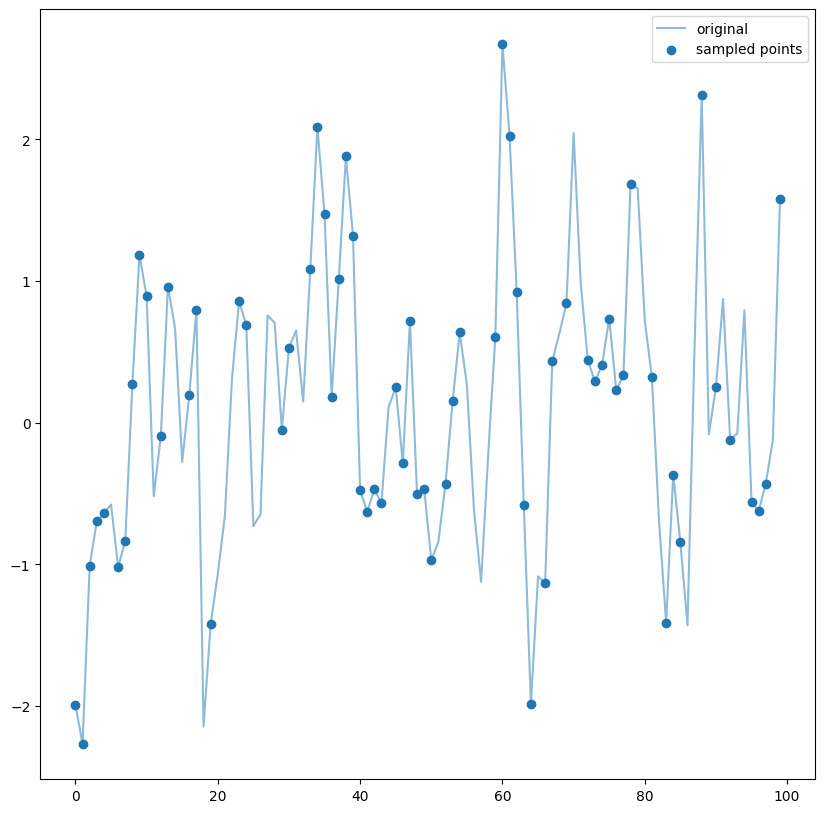

In [5]:
fig = plt.figure(figsize=[10,10])
plt.plot(np.arange(0, 100, 1), data[:100,1,0], label="original", alpha=0.5)
# plt.plot(np.arange(0, 100, 1), interp_data[:100,1,0], label="interp", c="red")
plt.scatter(np.argwhere(mask[:100,1,0]), data[np.argwhere(mask[:100,1,0]),1,0], label="sampled points")
plt.legend()
plt.show()

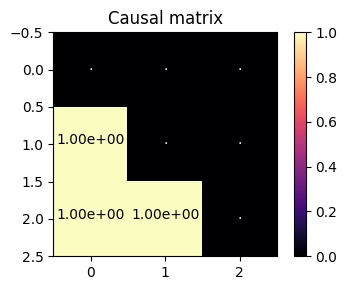

In [6]:
sub_cg = plot_causal_matrix(true_cm, figsize=[4, 3], vmin=0, vmax=1)
plt.show()

In [7]:
multicad = CUTS(opt.cuts, log, device=device)
multicad.train(interp_data, mask, data, true_cm)


Using masked supervision for data prediction (masked_before_50)......


 10%|█         | 10/100 [00:26<03:42,  2.47s/it, S2 loss=0.72, spr=0.36, auc=1.0000]

Data update started!


 50%|█████     | 50/100 [02:14<02:16,  2.73s/it, S2 loss=0.74, spr=0.35, auc=1.0000]

Using full supervision for data prediction......


100%|██████████| 100/100 [04:28<00:00,  2.69s/it, S2 loss=0.60, spr=0.34, auc=1.0000]


[[0.01827772 0.01798688 0.01829137]
 [0.98228604 0.0204882  0.01817936]
 [0.9822422  0.9861487  0.01460171]]


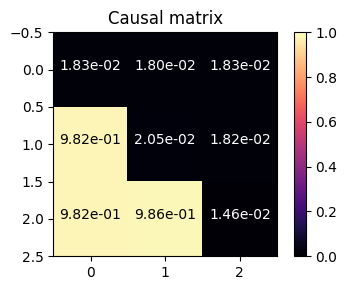

In [10]:
time_prob_mat = torch.sigmoid(multicad.graph).detach().cpu().numpy()
summary_mat = np.max(time_prob_mat, axis=2)
print(summary_mat)
sub_cg = plot_causal_matrix(summary_mat, figsize=[4, 3], vmin=0, vmax=1)
plt.show()